#GIN Using Default values: Politifact and BERT

In [1]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-+.html
Looking in links: https://data.pyg.org/whl/torch-+.html


In [2]:
from torch_geometric.datasets import UPFD #importing the UPFD Dataset


In [3]:
test_data_pol = UPFD(root=".", name="politifact", feature="bert",split="test")
train_data_pol = UPFD(root=".", name="politifact", feature="bert", split="train")
val_data_pol = UPFD(root=".", name="politifact", feature="bert", split="val")
train_data_pol = train_data_pol + val_data_pol

print("Politifact Dataset")
print("Train Samples: ", len(train_data_pol))
print("Validation Samples: ", len(val_data_pol))
print("Test Samples: ", len(test_data_pol))

Politifact Dataset
Train Samples:  93
Validation Samples:  31
Test Samples:  221


In [ ]:
train_data_pol[0].edge_index


tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  8,  8,  8, 16, 16, 16, 16, 16, 16,
         24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
         24, 24, 24, 24, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 60],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
         37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
         55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]])

##Loading Dataset Using DataLoader for train data and test data of Politifact

In [ ]:
from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_data_pol, batch_size=256, shuffle=True)
test_loader = DataLoader(test_data_pol, batch_size=256, shuffle=False)

In [ ]:
import torch
import torch.nn.functional as F
from torch.nn import LeakyReLU, Softmax, Linear, SELU,Dropout
from torch_geometric.nn import SAGEConv, global_max_pool, GATv2Conv, TopKPooling, global_mean_pool
from torch_geometric.transforms import ToUndirected
from torch.nn import LeakyReLU


##Defining Architecture of GIN Using 3 GIN Convolutional layers  with 3 unit MLP

In [ ]:
import torch.nn.functional as F
from torch.nn import Linear, Sequential, ReLU
from torch_geometric.nn import GINConv, global_max_pool

class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(Net, self).__init__()
        self.conv1 = GINConv(Sequential(Linear(in_channels, hidden_channels[0]), ReLU()))
        self.conv2 = GINConv(Sequential(Linear(hidden_channels[0], hidden_channels[1]), ReLU()))
        self.conv3 = GINConv(Sequential(Linear(hidden_channels[1], hidden_channels[2]), ReLU()))

        self.full1 = Linear(hidden_channels[2], hidden_channels[3])
        self.full2 = Linear(hidden_channels[3], hidden_channels[4])
        self.full3 = Linear(hidden_channels[4], hidden_channels[5])

        self.softmax = Linear(hidden_channels[5], out_channels)

        # dropouts
        self.dp1 = torch.nn.Dropout(0.2)
        self.dp2 = torch.nn.Dropout(0.2)
        self.dp3 = torch.nn.Dropout(0.2)

    def forward(self, x, edge_index, batch):
        h = self.conv1(x, edge_index)
        h = F.relu(h)
        h = self.conv2(h, edge_index)
        h = F.relu(h)
        h = self.conv3(h, edge_index)
        h = F.relu(h)

        h = global_max_pool(h, batch)

        h = self.full1(h)
        h = F.relu(h)
        h = self.dp1(h)
        h = self.full2(h)
        h = F.relu(h)
        h = self.dp2(h)
        h = self.full3(h)
        h = F.relu(h)
        h = self.dp3(h)

        h = self.softmax(h)

        return torch.sigmoid(h)


In [ ]:
from torch.autograd import Variable
from sklearn.metrics import accuracy_score, f1_score 

##Train and Test of model using Hyperparameters

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(test_data_pol.num_features,[512,512,512,256,256,256],1).to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #using adam optimiser and the learning rate as lr= 0.0001
lossff = torch.nn.BCELoss() #binary cross entropy loss
print(device)

cpu


In [ ]:
def train(epoch):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        # print(out)

        loss = lossff(torch.reshape(out,(-1,)), data.y.float())
        # print(loss)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def test(epoch):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    for data in test_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        # print(out)
        loss = lossff(torch.reshape(out,(-1,)), data.y.float())
        # print(loss)
        total_loss += float(loss) * data.num_graphs
        all_preds.append(torch.reshape(out, (-1,)))
        all_labels.append(data.y.float())
    # print(all_preds)
    accuracy, f1 = metrics(all_preds, all_labels)
    return total_loss / len(test_loader.dataset), accuracy, f1


def metrics(preds, gts):
    preds = torch.round(torch.cat(preds))
    gts = torch.cat(gts)
    # print(preds.cpu().numpy())

    acc = accuracy_score(preds.cpu().numpy(), gts.cpu().numpy())
    f1 = f1_score(preds.cpu().numpy(), gts.cpu().numpy())
    return acc, f1



In [ ]:
import matplotlib.pyplot as plt

wloss = []
train_losses = []
test_losses = []
test_accs = []
weighted_loss = 0
exp_param = 0.8
best_test_loss = float('inf')

for epoch in range(500):
  train_loss = train(epoch)
  test_loss, test_acc, test_f1 = test(epoch)
  weighted_loss = exp_param * (weighted_loss) + (1 - exp_param) * (test_loss / len(test_loader.dataset))
  
  wloss.append(weighted_loss / (1 - exp_param ** (epoch + 1)))
  train_losses.append(train_loss)
  test_losses.append(test_loss)
  test_accs.append(test_acc)

  if test_loss < best_test_loss:
    best_test_loss = test_loss

  print(f'Epoch: {epoch:02d} |  TrainLoss: {train_loss:.5f} | '
        f'TestLoss: {test_loss:.5f} | TestAcc: {test_acc:.5f} | TestF1: {test_f1:.2f}')



Epoch: 00 |  TrainLoss: 0.69646 | TestLoss: 0.69281 | TestAcc: 0.51131 | TestF1: 0.68
Epoch: 01 |  TrainLoss: 0.69417 | TestLoss: 0.69280 | TestAcc: 0.51131 | TestF1: 0.68
Epoch: 02 |  TrainLoss: 0.69488 | TestLoss: 0.69282 | TestAcc: 0.51131 | TestF1: 0.68
Epoch: 03 |  TrainLoss: 0.69531 | TestLoss: 0.69282 | TestAcc: 0.51131 | TestF1: 0.68
Epoch: 04 |  TrainLoss: 0.69373 | TestLoss: 0.69292 | TestAcc: 0.63801 | TestF1: 0.73
Epoch: 05 |  TrainLoss: 0.69507 | TestLoss: 0.69305 | TestAcc: 0.49774 | TestF1: 0.07
Epoch: 06 |  TrainLoss: 0.69079 | TestLoss: 0.69313 | TestAcc: 0.48869 | TestF1: 0.00
Epoch: 07 |  TrainLoss: 0.69321 | TestLoss: 0.69318 | TestAcc: 0.48869 | TestF1: 0.00
Epoch: 08 |  TrainLoss: 0.69570 | TestLoss: 0.69316 | TestAcc: 0.48869 | TestF1: 0.00
Epoch: 09 |  TrainLoss: 0.69299 | TestLoss: 0.69318 | TestAcc: 0.48869 | TestF1: 0.00
Epoch: 10 |  TrainLoss: 0.69009 | TestLoss: 0.69324 | TestAcc: 0.48869 | TestF1: 0.00
Epoch: 11 |  TrainLoss: 0.69161 | TestLoss: 0.69335 | 

##Plot of Test Accuracy over best Loss and Best Accuracy Epoch

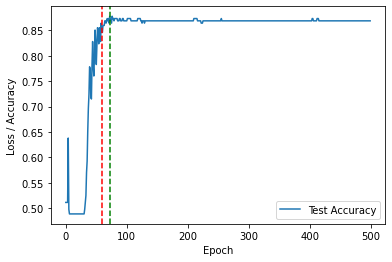

In [ ]:
plt.plot(test_accs, label='Test Accuracy')

# Add legend and axis labels
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')

# Add marker for best epoch
best_epoch_loss = test_losses.index(min(test_losses))
best_epoch_acc = test_accs.index(max(test_accs))
plt.axvline(x=best_epoch_loss, color='r', linestyle='--', label='Best Loss Epoch')
plt.axvline(x=best_epoch_acc, color='g', linestyle='--', label='Best Acc Epoch')

plt.show()

#GIN on BERT Embeddings using Optimal Values

In [ ]:
def objective(trial):
    model = Net(in_channels=768, hidden_channels=[trial.suggest_int(name="layer_size1", low=256, high=512, step=128),
                                                  trial.suggest_int(name="layer_size2", low=256, high=512, step=128),
                                                  trial.suggest_int(name="layer_size3", low=256, high=512, step=128),
                                                  trial.suggest_int(name="layer_size4", low=64, high=256, step=64),
                                                  trial.suggest_int(name="layer_size5", low=64, high=256, step=64),
                                                 ],
                out_channels=1).to(device)
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=trial.suggest_loguniform('learning_rate', 1e-6, 1e-3),
                                 betas=(trial.suggest_loguniform('b1', 1-1e-1,1-1e-3), 0.99))
    lossff = torch.nn.BCELoss()

    total_loss = 0
    weighted_loss = 0
    exp_param = 0.8
    wloss = []
    best_val = 1

    for i in range(1600):
        print("Epoch:", i)
        model.train()
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.batch)
            loss = lossff(torch.reshape(out,(-1,)), data.y.float())
            loss.backward()
            optimizer.step()
            total_loss += float(loss) * data.num_graphs
        print("Train: ",total_loss / len(train_loader.dataset))

        model.eval()
        total_loss = 0
        for data in val_loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            loss = lossff(torch.reshape(out,(-1,)), data.y.float())
            total_loss += float(loss) * data.num_graphs

        print("Test", total_loss / len(val_loader.dataset))

        weighted_loss = exp_param*(weighted_loss) + (1-exp_param)*(total_loss/ len(val_loader.dataset))
        print(weighted_loss/(1-exp_param**(i+1)))
        wloss.append(weighted_loss/(1-exp_param**(i+1)))

        if(best_val>weighted_loss/(1-exp_param**(i+1))):
            best_val = weighted_loss/(1-exp_param**(i+1))

        if(i-10>=0 and wloss[i-10]-weighted_loss<-0.01):
            break

    return best_val


##Training Our Model using Optuna

In [ ]:
!pip install optuna

In [ ]:
def objective(trial):
    model = Net(in_channels=768, 
                hidden_channels=[trial.suggest_int(name=f"hidden_size_{i}", low=256, high=512, step=128) for i in range(6)],
                out_channels=1).to(device)
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=trial.suggest_loguniform('learning_rate', 1e-6, 1e-3),
                                 betas=(trial.suggest_loguniform('b1', 1-1e-1,1-1e-3), 0.99))
    loss_func = torch.nn.BCELoss()

    total_loss = 0
    weighted_loss = 0
    exp_param = 0.8

    wloss = []
    best_val = 1

    for i in range(1600):
        print("Epoch:", i)
        model.train()
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.batch)
            loss = loss_func(torch.reshape(out,(-1,)), data.y.float())
            loss.backward()
            optimizer.step()
            total_loss += float(loss) * data.num_graphs
        print("Train: ",total_loss / len(train_loader.dataset))

        model.eval()
        total_loss = 0
        for data in val_loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            loss = loss_func(torch.reshape(out,(-1,)), data.y.float())
            total_loss += float(loss) * data.num_graphs

        print("Val: ", total_loss / len(val_loader.dataset))

        weighted_loss = exp_param * weighted_loss + (1-exp_param) * (total_loss / len(val_loader.dataset))
        print(weighted_loss / (1-exp_param**(i+1)))
        wloss.append(weighted_loss / (1-exp_param**(i+1)))

        if best_val > weighted_loss / (1-exp_param**(i+1)):
            best_val = weighted_loss / (1-exp_param**(i+1))

        if i - 10 >= 0 and wloss[i-10] - weighted_loss < -0.01:
            break

    return best_val


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def objective(trial):
    model = Net(in_channels=768, 
                hidden_channels=[trial.suggest_int(name=f"hidden_size_{i}", low=256, high=512, step=128) for i in range(6)],
                out_channels=1).to(device)
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=trial.suggest_loguniform('learning_rate', 1e-6, 1e-3),
                                 betas=(trial.suggest_loguniform('b1', 1-1e-1,1-1e-3), 0.99))
    loss_func = torch.nn.BCELoss()

    total_loss = 0
    weighted_loss = 0
    exp_param = 0.8

    wloss = []
    best_val = 1

    for i in range(1600):
        print("Epoch:", i)
        model.train()
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.batch)
            loss = loss_func(torch.reshape(out,(-1,)), data.y.float())
            loss.backward()
            optimizer.step()
            total_loss += float(loss) * data.num_graphs
        print("Train: ",total_loss / len(train_loader.dataset))

        model.eval()
        total_loss = 0
        for data in test_loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            loss = loss_func(torch.reshape(out,(-1,)), data.y.float())
            total_loss += float(loss) * data.num_graphs

        print("Test: ", total_loss / len(test_loader.dataset))

        weighted_loss = exp_param * weighted_loss + (1-exp_param) * (total_loss / len(test_loader.dataset))
        print(weighted_loss / (1-exp_param**(i+1)))
        wloss.append(weighted_loss / (1-exp_param**(i+1)))

        if best_val > weighted_loss / (1-exp_param**(i+1)):
            best_val = weighted_loss / (1-exp_param**(i+1))

        if i - 10 >= 0 and wloss[i-10] - weighted_loss < -0.01:
            break

    return best_val


In [ ]:
import optuna 
study = optuna.create_study(direction = "minimize", sampler = optuna.samplers.TPESampler())
study.optimize(objective, n_trials = 3, timeout=3600)

[I 2023-05-15 17:42:33,798] A new study created in memory with name: no-name-c01bad10-77e8-41f9-aaa7-eafce3b06b3c
/var/folders/q8/cv7jrv9n5tx6ydvwt_sft3640000gn/T/ipykernel_92563/1571534392.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  lr=trial.suggest_loguniform('learning_rate', 1e-6, 1e-3),
/var/folders/q8/cv7jrv9n5tx6ydvwt_sft3640000gn/T/ipykernel_92563/1571534392.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  betas=(trial.suggest_loguniform('b1', 1-1e-1,1-1e-3), 0.99))


Epoch: 0
Train:  0.6936161518096924
Test:  0.6930882334709167
0.6930882334709166
Epoch: 1
Train:  2.3396491574984726
Test:  0.6930922865867615
0.6930904852019416
Epoch: 2
Train:  2.338781647143825
Test:  0.6930826902389526
0.693087290544979
Epoch: 3
Train:  2.3379109668475326
Test:  0.6930773854255676
0.6930839351522244
Epoch: 4
Train:  2.3395435681907077
Test:  0.6930771470069885
0.6930819158324851
Epoch: 5
Train:  2.3390733170252975
Test:  0.6930758357048035
0.6930802677798349
Epoch: 6
Train:  2.337769091129303
Test:  0.6930808424949646
0.6930804132249021
Epoch: 7
Train:  2.3388548858704103
Test:  0.6930841207504272
0.6930813042130058
Epoch: 8
Train:  2.3385479636089777
Test:  0.6930885314941406
0.6930829737508026
Epoch: 9
Train:  2.340692052918096
Test:  0.6930946707725525
0.6930855945626857
Epoch: 10
Train:  2.337180729194354
Test:  0.6930986642837524
0.6930884541429755
Epoch: 11
Train:  2.3385548078885643
Test:  0.6931004524230957
0.6930910308703568
Epoch: 12
Train:  2.33847167671

[I 2023-05-15 17:45:32,425] Trial 0 finished with value: 0.37949389343331275 and parameters: {'hidden_size_0': 256, 'hidden_size_1': 256, 'hidden_size_2': 256, 'hidden_size_3': 384, 'hidden_size_4': 384, 'hidden_size_5': 512, 'learning_rate': 1.7023104360630722e-05, 'b1': 0.9217182628689928}. Best is trial 0 with value: 0.37949389343331275.


Test:  0.40157508850097656
0.3967615220777521
Epoch: 0
Train:  0.694062352180481
Test:  0.6933193206787109
0.6933193206787109
Epoch: 1
Train:  2.338384054040396
Test:  0.6938725113868713
0.6936266488499113
Epoch: 2
Train:  2.3393227586182217
Test:  0.6949629783630371
0.6941743248798808
Epoch: 3
Train:  2.342774059182854
Test:  0.695854663848877
0.6947435453978335
Epoch: 4
Train:  2.3443005405446535
Test:  0.6960716247558594
0.6951386189812537
Epoch: 5
Train:  2.347384657270165
Test:  0.6948592662811279
0.69506289886781
Epoch: 6
Train:  2.3397627229331643
Test:  0.6932578086853027
0.6946060786980415
Epoch: 7
Train:  2.3324588524397982
Test:  0.6920681595802307
0.693996169008452
Epoch: 8
Train:  2.3310415462781022
Test:  0.6901361346244812
0.6931044819160255
Epoch: 9
Train:  2.3256977027462375
Test:  0.6883214116096497
0.692032796510547
Epoch: 10
Train:  2.319520684339667
Test:  0.6858917474746704
0.6906891700710588
Epoch: 11
Train:  2.3050016536507556
Test:  0.6818535327911377
0.6887916

[I 2023-05-15 17:45:59,689] Trial 1 finished with value: 0.4990252936120282 and parameters: {'hidden_size_0': 512, 'hidden_size_1': 256, 'hidden_size_2': 512, 'hidden_size_3': 384, 'hidden_size_4': 384, 'hidden_size_5': 384, 'learning_rate': 0.00033541101797643905, 'b1': 0.9171546381469242}. Best is trial 0 with value: 0.37949389343331275.


Test:  0.699033796787262
0.574116555861709
Epoch: 0
Train:  0.6916696429252625
Test:  0.6937035322189331
0.6937035322189331
Epoch: 1
Train:  2.3396504688006576
Test:  0.6937196254730225
0.6937124729156495
Epoch: 2
Train:  2.340093010215349
Test:  0.693738579750061
0.6937231724379492
Epoch: 3
Train:  2.3433145624335094
Test:  0.6937538385391235
0.6937335606836045
Epoch: 4
Train:  2.3404746600376662
Test:  0.6937564015388489
0.6937403553216471
Epoch: 5
Train:  2.341153448627841
Test:  0.6937583684921265
0.6937452378923599
Epoch: 6
Train:  2.339565069444718
Test:  0.6937609314918518
0.6937492095237242
Epoch: 7
Train:  2.34300039404182
Test:  0.6937574148178101
0.6937511814101937
Epoch: 8
Train:  2.3404891189708503
Test:  0.6937578320503235
0.6937527177410576
Epoch: 9
Train:  2.3379314022679485
Test:  0.6937631368637085
0.6937550522293606
Epoch: 10
Train:  2.3424881472382495
Test:  0.6937649250030518
0.6937572123358319
Epoch: 11
Train:  2.338790113567024
Test:  0.6937656402587891
0.6937590

[I 2023-05-15 17:53:16,778] Trial 2 finished with value: 0.38280872752152595 and parameters: {'hidden_size_0': 512, 'hidden_size_1': 384, 'hidden_size_2': 384, 'hidden_size_3': 384, 'hidden_size_4': 256, 'hidden_size_5': 256, 'learning_rate': 1.0437634068410516e-05, 'b1': 0.9327956414431716}. Best is trial 0 with value: 0.37949389343331275.


Test:  0.44542020559310913
0.44053945823665774


In [ ]:
best_trial = study.best_trial
print("Best value:", best_trial.value)
print("Best parameters:", best_trial.params)

Best value: 0.37949389343331275
Best parameters: {'hidden_size_0': 256, 'hidden_size_1': 256, 'hidden_size_2': 256, 'hidden_size_3': 384, 'hidden_size_4': 384, 'hidden_size_5': 512, 'learning_rate': 1.7023104360630722e-05, 'b1': 0.9217182628689928}


##Using optimal hyperparameters 

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(test_data_pol.num_features,
            [256, 256, 256, 384, 384, 512],
            1).to(device)
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1.7023104360630722e-05,
                             betas=(0.9217182628689928, 0.99))
lossff = torch.nn.BCELoss()
print(device)


cpu


In [ ]:
def train(epoch):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        # print(out)

        loss = lossff(torch.reshape(out,(-1,)), data.y.float())
        # print(loss)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def test(epoch):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    for data in test_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        # print(out)
        loss = lossff(torch.reshape(out,(-1,)), data.y.float())
        # print(loss)
        total_loss += float(loss) * data.num_graphs
        all_preds.append(torch.reshape(out, (-1,)))
        all_labels.append(data.y.float())
    # print(all_preds)
    accuracy, f1 = metrics(all_preds, all_labels)
    return total_loss / len(test_loader.dataset), accuracy, f1


def metrics(preds, gts):
    preds = torch.round(torch.cat(preds))
    gts = torch.cat(gts)
    # print(preds.cpu().numpy())

    acc = accuracy_score(preds.cpu().numpy(), gts.cpu().numpy())
    f1 = f1_score(preds.cpu().numpy(), gts.cpu().numpy())
    return acc, f1

In [ ]:
import matplotlib.pyplot as plt

wloss = []
train_losses = []
test_losses = []
test_accs = []
weighted_loss = 0
exp_param = 0.8
best_test_loss = float('inf')

for epoch in range(500):
  train_loss = train(epoch)
  test_loss, test_acc, test_f1 = test(epoch)
  weighted_loss = exp_param * (weighted_loss) + (1 - exp_param) * (test_loss / len(test_loader.dataset))
  
  wloss.append(weighted_loss / (1 - exp_param ** (epoch + 1)))
  train_losses.append(train_loss)
  test_losses.append(test_loss)
  test_accs.append(test_acc)

  if test_loss < best_test_loss:
    best_test_loss = test_loss

  print(f'Epoch: {epoch:02d} |  TrainLoss: {train_loss:.5f} | '
        f'TestLoss: {test_loss:.5f} | TestAcc: {test_acc:.5f} | TestF1: {test_f1:.2f}')


Epoch: 00 |  TrainLoss: 0.69329 | TestLoss: 0.69326 | TestAcc: 0.48869 | TestF1: 0.00
Epoch: 01 |  TrainLoss: 0.69389 | TestLoss: 0.69326 | TestAcc: 0.48869 | TestF1: 0.00
Epoch: 02 |  TrainLoss: 0.69397 | TestLoss: 0.69326 | TestAcc: 0.48869 | TestF1: 0.00
Epoch: 03 |  TrainLoss: 0.69301 | TestLoss: 0.69327 | TestAcc: 0.48869 | TestF1: 0.00
Epoch: 04 |  TrainLoss: 0.69269 | TestLoss: 0.69327 | TestAcc: 0.48869 | TestF1: 0.00
Epoch: 05 |  TrainLoss: 0.69324 | TestLoss: 0.69328 | TestAcc: 0.48869 | TestF1: 0.00
Epoch: 06 |  TrainLoss: 0.69263 | TestLoss: 0.69328 | TestAcc: 0.48869 | TestF1: 0.00
Epoch: 07 |  TrainLoss: 0.69217 | TestLoss: 0.69329 | TestAcc: 0.48869 | TestF1: 0.00
Epoch: 08 |  TrainLoss: 0.69245 | TestLoss: 0.69330 | TestAcc: 0.48869 | TestF1: 0.00
Epoch: 09 |  TrainLoss: 0.69263 | TestLoss: 0.69331 | TestAcc: 0.48869 | TestF1: 0.00
Epoch: 10 |  TrainLoss: 0.69196 | TestLoss: 0.69332 | TestAcc: 0.48869 | TestF1: 0.00
Epoch: 11 |  TrainLoss: 0.69326 | TestLoss: 0.69333 | 

##Plot of Test Accuracy over best Loss and Best Accuracy Epoch

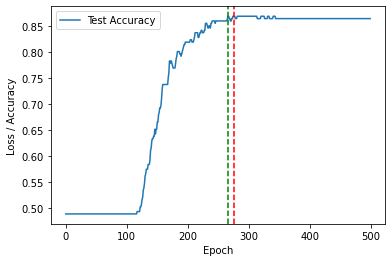

In [ ]:
plt.plot(test_accs, label='Test Accuracy')

# Add legend and axis labels
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')

# Add marker for best epoch
best_epoch_loss = test_losses.index(min(test_losses))
best_epoch_acc = test_accs.index(max(test_accs))
plt.axvline(x=best_epoch_loss, color='r', linestyle='--', label='Best Loss Epoch')
plt.axvline(x=best_epoch_acc, color='g', linestyle='--', label='Best Acc Epoch')

plt.show()